For this homework, make sure that you format your notbook nicely and cite all sources in the appropriate sections. Programmatically generate or embed any figures or graphs that you need.

Names: __Lucas Calero Forero, Rebecca McBrayer__

Step 1: Word2Vec paper questions
---------------------------
1. Describe how a CBOW word embedding is generated.

A feedforward Neural Net without a hidden layer with a shared projection layer is used to classify the current word on every iteration based on its context (previous and future words). The output is a word embedding of size V.

2. What is a CBOW word embedding and how is it different from a skip-gram word embedding?

A CBOW word embedding is a grouping of vectorized representation of words. Its generated using a Continuous Bag of Words model that predicts and weights the current word based on its context. 
The biggest difference between the skip-gram model and CBOW model is the fact that skip-gram uses the current word as the input into the classifier to predict words within a range R of the word 1 < R < C where C is the maxiumum distance. This technique allows for weighted classification depending on the distance from w(i) and the current word. 

Their embeddings are quite similar in the end, one factor to consider between the two is the fact that skip-gram can be more accurate with less data.

3. What is the task that the authors use to evaluate the generated word embeddings?

The authors use the Semantic-Syntactic Word Relationship test set to evaluate their generated word embeddings, a test set developed by them for this paper and for future research.

4. What are PCA and t-SNE? Why are these important to the task of training and interpreting word embeddings?

PCA and t-SNE are methods of dimensionality reduction, projecting high-dimensional word embeddings into lower dimensional space. This is important foor training and interpreting word embeddings since embeddings can become extremely high dimensional, and projecting them into a lower space will both speed up training time and make it easier for humans to visualize and therefore interpret.

Step 2: Train your own word embeddings
--------------------------------

The Spooky Authors dataset is an old competition dataset from Kaggle. It has example sentences from famous works of writing from three different authors. For this assignment, each data point is a single sentence written by one of the three gothic authors.

Describe what data set you have chosen to compare and contrast with the Spooky Authors Dataset. Make sure to describe where it comes from and its general properties.

We chose the text of Les Miserables as our second dataset. This comes from Project Gutenburg and has over 500,000 words in its translated form.

In [65]:
# import your libraries here
import string
import urllib.request
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize
import numpy as np
import pandas as pd
import tensorflow as tf

# Importing utility functions from Keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Embedding


In [66]:
# Variable Definitions
NGRAM = 3 # The size of the ngram language model you want to train

# The dimension of word embedding. 
# This variable will be used throughout the program
# you may vary this as you desire
EMBEDDINGS_SIZE = 200

### a) Train embeddings on GIVEN dataset

In [67]:
# Read the file 'spooky-author-identification/train.csv' 
spooky = pd.read_csv('train.csv')

In [68]:
# Manipulate the data to get a dictionary of author : {set of unique words for each author}
spooky_author = spooky[["text","author"]].groupby("author")["text"].apply(list).reset_index(name='sentences')
spooky_author["sentences"] = spooky_author["sentences"].apply(lambda a: [s.split() for s in a])

spooky_author_dict = {}

common_words = set()
for index, row in spooky_author.iterrows():
        words = set([w.lower() for s in row["sentences"] for w in s])
        spooky_author_dict[row["author"]] = words
        common_words.update(words)

#Create intersection of all authors to get words in common between all three authors
for _, words in spooky_author_dict.items():
    common_words.intersection_update(words)

# Take the difference for each author
for author,words in spooky_author_dict.items():
    spooky_author_dict[author] = words.difference(common_words)



In [69]:
# code to train your word embeddings
spooky_text = list(spooky['text'])

# Remove punctuation
exclude = set(string.punctuation)
spooky_nopun = []
for st in spooky_text:
    st = ''.join(ch for ch in st if ch not in exclude)
    spooky_nopun.append(st)

# Add start and ending tokens, and make all words lowercase
spooky_text = ["{} {} {}".format("".join(["<s> "] * (NGRAM - 1)),sentence.lower(),"".join(["</s> "] * (NGRAM-1))) for sentence in spooky_nopun]
spooky_data = [sentence.split() for sentence in spooky_text]
spooky_data = list(filter(lambda a: len(a)>(NGRAM-1)*2, spooky_data))  # Remove blank sentences


In [70]:
# Train the Word2Vec model from Gensim. 
# Below are the hyperparameters that are most relevant. 
# But feel free to explore other 
# options too:
# sg = 1
# window = 5
# size = EMBEDDING_SIZE
# min_count = 1

spooky_model = Word2Vec(sentences=spooky_data, size=EMBEDDINGS_SIZE, window=7, min_count=2, workers=4, sg=1)
spooky_model.save("word2vec.model")

In [71]:
# if you save your Word2Vec as the variable model, this will 
# print out the vocabulary size
print('Vocab size {}'.format(len(spooky_model.wv.vocab)))

Vocab size 15935


In [72]:
# You can save file in txt format, then load later if you wish.
spooky_model.wv.save_word2vec_format('embeddings.txt', binary=False)

### b) Train embedding on YOUR dataset

In [73]:
# Pull the data from Project Gutenburg
with urllib.request.urlopen("http://www.gutenberg.org/files/135/135-0.txt") as f:
    content = f.read()

text = content.decode('utf-8-sig')

# Remove parts of the text that aren't the book itself, plus extraneous whitespace
text = text[text.find("So long as there shall exist"):text.find("Publisher of the Italian translation ")]
# text = ''.join(ch for ch in text if ch not in ['\n','\r'])
text = text.replace('\n', ' ').replace('\r', ' ')

# Tokenize
sentences = sent_tokenize(text)

In [74]:
# Remove punctuation
exclude = set(string.punctuation)
text_nopun = []
for st in sentences:
    st = ''.join(ch for ch in st if ch not in exclude)
    text_nopun.append(st)

# Add start and ending tokens, and make all words lowercase
text = ["{} {} {}".format("".join(["<s> "] * (NGRAM-1)),sentence.lower(),"".join(["</s> "] * (NGRAM-1))) for sentence in text_nopun]
lesmis_data = [sentence.split() for sentence in text]
lesmis_data = list(filter(lambda a: len(a)>(NGRAM-1)*2, lesmis_data))  # Remove blank sentences


In [75]:
# Train the Word2Vec model from Gensim. 
# Below are the hyperparameters that are most relevant. 
# But feel free to explore other 
# options too:
# sg = 1
# window = 5
# size = EMBEDDING_SIZE
# min_count = 1

lesmis_model = Word2Vec(sentences=lesmis_data, size=EMBEDDINGS_SIZE, window=7, min_count=2, workers=4, sg=1)
lesmis_model.save("lesmis_word2vec.model")

In [76]:
# lesmis_model.wv.save_word2vec_format('lesmis_embeddings.txt', binary=False)
print('Vocab size {}'.format(len(lesmis_model.wv.vocab)))

Vocab size 15607


What text-normalization and pre-processing did you do and why? __We chose to do only very minimal text preprocessing, to keep our implementation simple. We removed punctuation and made all words lowercase, since those have no impact on the meaning of words (and therefore how they should be represented by an embedding. We added start and end tokens to make learning easier, but otherwise left the sentences alone. We did not lemmatize, as the different forms of words will have different meanings and therefore we decided to let them be embedded differently.__

Step 3: Evaluate the differences between the word embeddings
----------------------------

(make sure to include graphs, figures, and paragraphs with full sentences)

In [77]:
spooky_model.wv.similar_by_word('king')

[('title', 0.9108554124832153),
 ('relatives', 0.9051833152770996),
 ('allotted', 0.9005166292190552),
 ('distinction', 0.8927980661392212),
 ('repair', 0.8924698829650879),
 ('relative', 0.8916993737220764),
 ('gazette', 0.8915106058120728),
 ('alfred', 0.8913006782531738),
 ('enterprise', 0.8908143043518066),
 ('proud', 0.8905656933784485)]

In [78]:
lesmis_model.wv.similar_by_word('king')

[('philippe', 0.8556502461433411),
 ('xvi', 0.8541892170906067),
 ('spanish', 0.8536829948425293),
 ('1830', 0.837654709815979),
 ('republic', 0.8353723287582397),
 ('witness', 0.8336400985717773),
 ('minister', 0.8329614996910095),
 ('france', 0.8322767019271851),
 ('abbé', 0.8288772702217102),
 ('title', 0.8284268379211426)]

In [79]:
def display_closestwords_tsnescatterplot(model, word):
    
    arr = np.empty((0,200), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.wv.similar_by_word(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model.wv[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model.wv[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

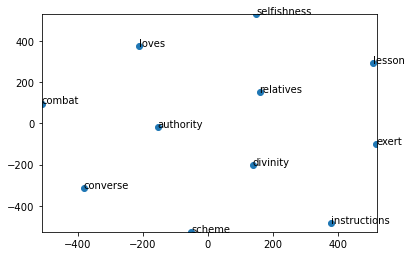

In [80]:
display_closestwords_tsnescatterplot(spooky_model, 'relatives')

In [81]:
lesmis_result = lesmis_model.wv.most_similar(positive=['woman', 'king'], negative=['man'])
spooky_result = spooky_model.wv.most_similar(positive=['woman', 'king'], negative=['man'])

print("Top 5 most similar words for the woman + king - man vector")
print("(Which should equal to queen in an ideal world)\n")
for i in range(0,5):
    lesmis_most_similar_key, lesmis_similarity = lesmis_result[i]  # look at the first match
    spooky_most_similar_key, spooky_similarity = spooky_result[i]  # look at the first match

    print(f"LesMis: {lesmis_most_similar_key}: {lesmis_similarity:.4f}")
    print(f"Spooky: {spooky_most_similar_key}: {spooky_similarity:.4f}")
print("\n--------\n")
print("Spooky King count:",spooky_model.wv.vocab["king"])
print("Spooky Queen count:{}\n".format(spooky_model.wv.vocab["queen"]))
print("Lesmis King count:",lesmis_model.wv.vocab["king"])
print("Lesmis Queen count:",lesmis_model.wv.vocab["queen"])


Top 5 most similar words for the woman + king - man vector
(Which should equal to queen in an ideal world)

LesMis: xvi: 0.7661
Spooky: neglected: 0.8999
LesMis: convent: 0.7386
Spooky: attended: 0.8863
LesMis: philippe: 0.7297
Spooky: birth: 0.8797
LesMis: interests: 0.7289
Spooky: arranging: 0.8783
LesMis: louis: 0.7254
Spooky: park: 0.8744

--------

Spooky King count: Vocab(count:55, index:936, sample_int:4294967296)
Spooky Queen count:Vocab(count:18, index:2829, sample_int:4294967296)

Lesmis King count: Vocab(count:107, index:511, sample_int:4294967296)
Lesmis Queen count: Vocab(count:8, index:5162, sample_int:4294967296)


In [82]:
result = lesmis_model.wv.most_similar(positive=['woman', 'king'], negative=['man'])
most_similar_key, similarity = result[0]  # look at the first match
print(f"{most_similar_key}: {similarity:.4f}")

xvi: 0.7661


In [83]:
labels = ['EAP', 'Common', 'HPL', 'MWS']
colors = ['r', 'g', 'b', 'c']
def labeller(word):
    for author, words in spooky_author_dict.items():
        if word in words:
            return author
    return "Common"

def color_gen(label):
    for i in range(0,4):
        if label == labels[i]:
            return colors[i]
    return 'm'

In [88]:
vis_data = TSNE(n_components=2, random_state=0).fit_transform(spooky_model.wv.vectors)
label_data = [labeller(word) for word in list(spooky_model.wv.vocab.keys())]

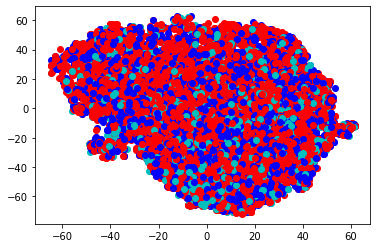

In [89]:
vis_x = vis_data[:, 0]
vis_y = vis_data[:, 1]

for x, y, c in zip(vis_x, vis_y,[color_gen(l) for l in label_data]):
    if c != 'g':
        plt.scatter(x, y, c= c)

plt.show()

In [86]:
vis_data = TSNE(n_components=2, random_state=0).fit_transform(lesmis_model.wv.vectors)

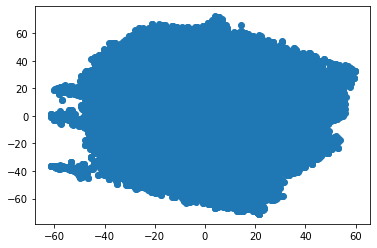

In [87]:
vis_x = vis_data[:, 0]
vis_y = vis_data[:, 1]
plt.scatter(vis_x, vis_y, cmap=plt.cm.get_cmap("jet", 10))
plt.clim(-0.5, 9.5)
plt.show()

Evaluate the differences between your two sets of learned word embeddings. You will need to do research/outside reading to determine the best way to evaluate these. If you want to visualize dense embeddings in 2-dimensional space to show this comparison, we recommend using a t-SNE projection (scikit-learn has an implementation of this that you are welcome to use).

    Produce any graphs or figures that illustrate what you have found and write 2 - 3 paragraphs describing the differences you find between your two sets of embeddings and why you see them.


We chose to work with the Les Miserables text from project guttenberg. We tried to replicate the example used in the word2vec paper where we add woman + king - man in an attenmpt to get the vector for queen. These are the top 5 closest vectors for that equation for both the spooky model and the lesmis model.

- LesMis: xviii: 0.7789
- Spooky: arranging: 0.8664
- LesMis: xvi: 0.7703
- Spooky: recalled: 0.8653
- LesMis: 1830: 0.7663
- Spooky: lespanaye: 0.8650
- LesMis: eighteenth: 0.7654
- Spooky: eldest: 0.8629
- LesMis: charles: 0.7534
- Spooky: married: 0.8555

As you can see, neither of the models produce queen, even though it does exist for both models. There could be a myriad of reasons why this doesn't happen, we think that its due to the limited amount of data that we have used. 

- Spooky King count: Vocab(count:55, index:936, sample_int:4294967296)
- Spooky Queen count:Vocab(count:18, index:2829, sample_int:4294967296)
- Lesmis King count: Vocab(count:107, index:511, sample_int:4294967296)
- Lesmis Queen count: Vocab(count:8, index:5162, sample_int:4294967296)

By looking at the count for both king and queen for both models, you can see that there is significantly more instances of 'king' than of 'queen' for both models. This could be an answer as to why the vector addition of woman + king - man does not equal queen for both models. Its also interesting to note that this example shows that both these models have gendered bias and we would be interested in working on different techniques for rectifying these biases.

We used T-SNE to reduce the dimentionality of our word embeddings and were able to label the plot of the spooky data embedding using the author label that came with the data. We struggled to find a similar way of classifying the Les Mis dataset, which explains why only the spooky dataset has a colorful plot. We decided to only display the words that were unique to each author in the hopes of showing that some clustering is created based on which author uses specific words. 

Cite your sources:
-------------

- https://medium.com/@aneesha/using-tsne-to-plot-a-subset-of-similar-words-from-word2vec-bb8eeaea6229
- https://indico.io/blog/visualizing-with-t-sne/

Step 4: Feedforward Neural Language Model
--------------------------

### a) First, encode  your text into integers

In [24]:
# Create word embedding dict to check if word exists in embedding (depending on if min_word>1)
spooky_embedding_dict = spooky_model.wv
lesmis_embedding_dict = lesmis_model.wv

In [25]:
flat_data = [word for sent in spooky_data for word in sent if word in spooky_embedding_dict]
spooky_vocab = list(set(flat_data))

# Initializing a Tokenizer
spooky_tokenizer = Tokenizer()
spooky_tokenizer.fit_on_texts(flat_data)

indexed_spooky_data = spooky_tokenizer.texts_to_sequences(spooky_data)
indexed_spooky_vocab = spooky_tokenizer.texts_to_sequences(spooky_vocab)

spooky_word_to_index = {word:index[0] for word, index in zip(list(spooky_vocab), indexed_spooky_vocab)}
spooky_index_to_word = {index[0]:word for word, index in zip(list(spooky_vocab), indexed_spooky_vocab)}

In [26]:
flat_data = [word for sent in lesmis_data for word in sent if word in lesmis_embedding_dict]
lesmis_vocab = list(set(flat_data))

# Initializing a Tokenizer
lesmis_tokenizer = Tokenizer()
lesmis_tokenizer.fit_on_texts(flat_data)

indexed_lesmis_data = lesmis_tokenizer.texts_to_sequences(lesmis_data)
indexed_lesmis_vocab = lesmis_tokenizer.texts_to_sequences(lesmis_vocab)

lesmis_word_to_index = {word:index[0] for word, index in zip(list(lesmis_vocab), indexed_lesmis_vocab)}
lesmis_index_to_word = {index[0]:word for word, index in zip(list(lesmis_vocab), indexed_lesmis_vocab)}

### b) Next, prepare your sequences from text

#### Fixed ngram based sequences (Used for Feedforward)

The training samples will be structured in the following format. 
Depending on which ngram model we choose, there will be (n-1) tokens 
in the input sequence (X) and we will need to predict the nth token (Y)

            X,						  y
    this,    process               however
    process, however               afforded
    however, afforded	           me

In [27]:
def generate_ngram_training_samples(content: list) -> list:
    '''
    Takes the encoded data (list of lists) and 
    generates the training samples out of it.
    Parameters:
    up to you, we've put in what we used
    but you can add/remove as needed
    return: 
    list of lists in the format [[x1, x2, ... , x(n-1), y], ...]
    '''
    ngrams = []
    for sent in content:
        for i in range(NGRAM-1, len(sent)):
            ngram = [sent[j] for j in range(i-(NGRAM-1), i+1)]
            ngrams.append(ngram)
    return ngrams

### c) Then, split the sequences into X and y and create a Data Generator

In [28]:
def read_embeddings(path: string, word_to_index: dict) -> (dict,dict):
    '''Loads and parses embeddings trained in earlier.
    Parameters and return values are up to you.
    '''
    # you may find generating the following two dicts useful:
    # word to embedding : {'the':1, ...}
    # index to embedding : {1:'the', ...} (inverse of word_2_embedding)
    
    model = Word2Vec.load(path)
    word_to_embedding = {}
    index_to_embedding = {}
    for word in model.wv.vocab.keys():
        index = word_to_index[word]
        embedding = model.wv[word]
        word_to_embedding[word] = embedding
        index_to_embedding[index] = embedding
    return word_to_embedding, index_to_embedding

### Create the x & y lists

In [29]:
def generate_encoded_input(source):
    ngram_source = generate_ngram_training_samples(source)
    encoded_X = []
    encoded_Y = []
    for ngram in ngram_source:
        encoded_X.append(ngram[:NGRAM-1])
        encoded_Y.append(ngram[-1])
        
    return encoded_X, encoded_Y

In [30]:
def data_generator(X: list, Y: list, vocab: list, 
                   num_sequences_per_batch: int, index_to_embedding: dict) -> (list,list):
    '''
    Returns data generator to be used by feed_forward
    https://wiki.python.org/moin/Generators
    https://realpython.com/introduction-to-python-generators/
    
    Yields batches of embeddings and labels to go with them.
    Use one hot vectors to encode the labels 
    (see the to_categorical function)
    
    '''
    num_sequences = 0
    
    while True:
        next_X = X[num_sequences: num_sequences+num_sequences_per_batch]
        next_X_vec = []
        for X_sent in next_X:
            X_sent_next = []
            for ii in X_sent:
                X_sent_next.extend(index_to_embedding[ii])
            next_X_vec.append(X_sent_next)
        
        next_Y = Y[num_sequences: num_sequences+num_sequences_per_batch]
        next_Y_cat = [tf.keras.utils.to_categorical(vec, num_classes=len(vocab)) for vec in next_Y]
        next_Y_tensor = np.array([tf.keras.backend.constant(cat) for cat in next_Y_cat])
        
        yield tf.keras.backend.constant(next_X_vec),next_Y_tensor
        num_sequences += num_sequences_per_batch

In [31]:
# initialize data_generator
def get_training_generator(source, vocab, encoded_X, encoded_Y, index_to_embedding):
    '''
    Sets parameters and collects data to build the data generator object
    '''
    sequences = source
    num_sequences_per_batch = 128 # this is the batch size
    steps_per_epoch = len(sequences)//num_sequences_per_batch  # Number of batches per epoch
    train_generator = data_generator(encoded_X, encoded_Y, vocab, num_sequences_per_batch, index_to_embedding)
    
    return train_generator, steps_per_epoch

# sample=next(train_generator) # this is how you get data out of generators
# sample[1].shape # (batch_size, (n-1)*EMBEDDING_SIZE)

### d) Train your models

In [32]:
# code to train a feedforward neural language model 
# on a set of given word embeddings

def create_model(model_size):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(64, input_dim=EMBEDDINGS_SIZE * (NGRAM-1)))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dense(model_size))
    model.add(tf.keras.layers.Activation('softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print(model.summary())
    return model    

In [33]:
# Start training the model
def train_model(model, train_generator, steps_per_epoch):
    history = model.fit(x=train_generator,
              steps_per_epoch=steps_per_epoch,
              epochs=3)
    print(history.history['accuracy'])
    return history

### e) Generate Sentences

In [34]:
# generate a sequence from the model
def generate_seq(model: Sequential,
                 seed: list, 
                 n_words: int,
                 word_to_embedding: dict,
                 index_to_word: dict):
    '''
    Parameters:
        model: your neural network (trained)
        seed: [w1, w2, w(n-1)]
        n_words: generate a sentence of length n_words
        word_to_embedding: dictionary mapping words to their embeddings
        index_to_word: dictionary mapping indexes to the words they reference
    Returns: string sentence
    '''
    # initialize prediction list
    prediction_list = seed
    
    # Build the sentence
    while len(prediction_list) < n_words:
    
        # get last (NGRAM-1) words of list
        sample = prediction_list[-(NGRAM-1):]
    
        # Convert to embeddings, reshape properly
        sample_embedded = [word_to_embedding[word] for word in sample]
        sample_embedded = np.array(sample_embedded).reshape(-1, (NGRAM-1)*EMBEDDINGS_SIZE)
    
        # generate new word from these
        probabilities = model.predict(sample_embedded)[0]
        predicted_word_index = np.random.choice(np.arange(len(probabilities)), 1, p=probabilities)[0]
        # predicted_word_index = probabilities.argmax()
    
        # convert new word index to word and add it to list
        predicted_word = index_to_word[predicted_word_index]
        prediction_list.append(predicted_word)
        if predicted_word == "</s>":
            break
    
    return " ".join(prediction_list)

In [35]:
# Spooky Model
spooky_filepath = "word2vec.model"
SPOOKY_MODEL_SIZE = 15935

# Gather the input data
spooky_word_to_embedding, spooky_index_to_embedding = read_embeddings(spooky_filepath, spooky_word_to_index)
spooky_encoded_X, spooky_encoded_Y = generate_encoded_input(indexed_spooky_data)
spooky_data_generator, steps_per_epoch = get_training_generator(indexed_spooky_data,
                                                                spooky_vocab,
                                                                spooky_encoded_X, 
                                                                spooky_encoded_Y, 
                                                                spooky_index_to_embedding)

# Train the model
spooky_model = create_model(SPOOKY_MODEL_SIZE)
spooky_history = train_model(spooky_model, spooky_data_generator, steps_per_epoch)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                25664     
_________________________________________________________________
activation (Activation)      (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 15935)             1035775   
_________________________________________________________________
activation_1 (Activation)    (None, 15935)             0         
Total params: 1,061,439
Trainable params: 1,061,439
Non-trainable params: 0
_________________________________________________________________
None
Train for 152 steps
Epoch 1/3
152/152 [==============================] - 18s 116ms/step - loss: 7.5569 - accuracy: 0.0583
Epoch 2/3
152/152 [==============================] - 18s 115ms/step - loss: 6.8928 - accuracy: 0.0837
Epoch 3/3
152/1

In [36]:
# Les Mis Model
lesmis_filepath = "lesmis_word2vec.model"
LESMIS_MODEL_SIZE = 15607

# gather the input data
lesmis_word_to_embedding, lesmis_index_to_embedding = read_embeddings(lesmis_filepath, lesmis_word_to_index)
lesmis_encoded_X, lesmis_encoded_Y = generate_encoded_input(indexed_lesmis_data)
lesmis_data_generator, steps_per_epoch = get_training_generator(indexed_lesmis_data,
                                                                lesmis_vocab,
                                                                lesmis_encoded_X, 
                                                                lesmis_encoded_Y, 
                                                                lesmis_index_to_embedding)

# Train the model
lesmis_model = create_model(LESMIS_MODEL_SIZE)
lesmis_history = train_model(lesmis_model, lesmis_data_generator, steps_per_epoch)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                25664     
_________________________________________________________________
activation_2 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 15607)             1014455   
_________________________________________________________________
activation_3 (Activation)    (None, 15607)             0         
Total params: 1,040,119
Trainable params: 1,040,119
Non-trainable params: 0
_________________________________________________________________
None
Train for 229 steps
Epoch 1/3
229/229 [==============================] - 26s 113ms/step - loss: 7.1641 - accuracy: 0.0748
Epoch 2/3
229/229 [==============================] - 27s 118ms/step - loss: 6.7190 - accuracy: 0.0872
Epoch 3/3
229

In [37]:
# Spooky Sentences!
for _ in range(0,20):
    print(generate_seq(spooky_model, ["<s>", "<s>"], 20, spooky_word_to_embedding, spooky_index_to_word)[7:])

 to a penetrate i since the things both toiling bordered with who of has scoffed secret jupiter dimension
 which in over the merged of the bundle i they attempting unusually upon the breasts prisons us overflowing
 in had morning a headlands a favour resolution as to drawing that upon and raymond really said with
 to first school equally to majestic may walked the sickness depict of ten beautiful the sparkling of before
 of with imperceptible became sign the committed were be slowly of in unhealthy demonstrable joe most i bellows
 whom see men those happiest as should the monsieur damnable outside a ride the nature in a squat
 he not find of drew came was a will handkerchiefs ravishing the urge was frightened were the uttering
 very with a writing several needless an dulled you miserable for in is slowly struck is the relics
 we cannot glass apotheosis splendid heir hev built which a moved spoke i a gangs up different hand
 calm than his creative undisturbed do are when yours examine g

In [38]:
# Les Mis Sentences!
for _ in range(20):
    print(generate_seq(lesmis_model, ["<s>", "<s>"], 20, lesmis_word_to_embedding, lesmis_index_to_word)[7:])

 put that it was in a incline being please” and enigma lives a on reply to us i
 he the old survey to tried” threequarters away calculations a saying to visor which heart with the steadily
 he monarchy dint it to let aware it entered its curiosity to be did floor there her is
 if it for the sombre of hours she set enter the coarse who meaning you haste stood metaphor
 power over also him magistrate an demon and the perhaps answered no whom probably le no the far
 be thoughtfully you that why not taken men is the when he movement write the unequal before open
 not disentangle necessary that morning sorry words is said the notre who is bolts heaven which is him
 the an of his deuce” this woman longer nothing what who my colbas in his on the quitted
 a capstan lurked obscure produce of his “if never quality this course done red at cat so and
 famous five said to at the gleam and twilight altar beneath the violent was he youth upon he
 what it was the truths of te preached destinies “a he 

### f) Compare your generated sentences

*Compare these with sentences that could be produced using Shannon’s method with the statistical n-gram language models that we implemented earlier in the semester. Do your neural language models produce n-grams that were not observed during training? (1 paragraph, you may support this answer with code as desired).*

The sentences generated with feedforward network are more unique and varied than those generated using Shannon's method. Both the sentences here and those generated through Shannon's method make some level of grammatical sense, but at least with this data Shannon's method would perform better. Since the statistical way of generating sentences cannot create n-grams that did not occur in the training text, the Shannon's method sentences would appear more regular and contain more meaning. The sentences generated here include n-grams that were not observed during training, and there is little semantic sense contained in the majority of these sentences. The sentences generated from the Spooky Authors dataset are particularly nonsensical, and the sentences generated from Les Mis are ever so slightly more coherent. We assume this is because we had significantly more training data from Les Mis, and that if we trained these models with more information we would get increasingly comprehensible results. 

Sources Cited
----------------------------


https://keras.io/guides/sequential_model/